# Generating building blocks from a list of smiles

In this notebook we show how we can generate a list of building blocks from a list of smiles in an csv file

the first step is to generate a list of building block with defined connection points for the building bloakc from a set of fragment following some rules

In [1]:
import itertools
from rdkit.Chem import rdMolDescriptors
from rdkit import Chem
import pandas as pd
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import numpy as np
import os


In [4]:
# helper function to define building blocks from fragments
def fragment_from_smiles(smile):
    """
    This function takes a SMILES string as the initial molecular fragment and returns a list of RDKit molecules for the building blocks.
    Here we place a bromin atoms to identify the potential connection points.
    the building of an oligomer would use the stk.bromoFactory to connect the building blocks. 
     https://stk.readthedocs.io/en/stable/_autosummary/stk.BromoFactory.html#
    Parameters
    ----------
    smile : str
        SMILES string

    Returns
    -------
    mol_list : list
        list of RDKit molecules
    mol_list_smiles : list
        list of SMILES strings
    """

    mol2=Chem.MolFromSmiles(smile)
    mol2=Chem.AddHs(mol2)
    if rdMolDescriptors.CalcNumAromaticRings(mol2)>6:
        return [],[],[]
    if mol2.GetNumAtoms()>40:
        return [],[],[]
    potential_connection=[]
    for x in mol2.GetAtoms():
        #print(x.GetIdx(), x.GetHybridization())
        if x.GetAtomicNum() == 35 or x.GetAtomicNum() == 34 or x.GetAtomicNum() == 14 or x.GetAtomicNum() == 17:
            return [],[],[]
        if x.GetAtomicNum() == 6 and x.GetHybridization().name == 'SP2':
            for atom in x.GetNeighbors():
                if atom.GetAtomicNum() == 1:
                    potential_connection.append(atom.GetIdx())#atom.SetAtomicNum(35)
    mol_list = []
    mol_list_smiles=[]
    potential_connection=list(set(potential_connection))
    #print(potential_connection)
    #print(len(set(itertools.combinations(potential_connection, 2))))
    for atom1,atom2 in set(itertools.combinations(potential_connection, 2)):
        mol_trans=Chem.Mol(mol2)
        
        pass_case=False
        Neighbour_atom1 = mol_trans.GetAtoms()[atom1].GetNeighbors()
        Neighbour_atom2 = mol_trans.GetAtoms()[atom2].GetNeighbors()
        for atom1_N in Neighbour_atom1:
            for atom2_N in Neighbour_atom2:
                if atom1_N.GetIdx() == atom2_N.GetIdx():
                    pass_case=True
                    break
                if atom1_N.GetIdx() in [x.GetIdx() for x in atom2_N.GetNeighbors()]:
                    pass_case=True
                    break
                if len(set([x.GetIdx() for x in atom1_N.GetNeighbors()])\
                    .intersection(set([x.GetIdx() for x in atom2_N.GetNeighbors()])))>0:
                  #  print(len(set([x.GetIdx() for x in atom1_N.GetNeighbors()])\
                  #.intersection(set([x.GetIdx() for x in atom2_N.GetNeighbors()])))>0)
                    pass_case=True
                    break
        if pass_case:
            continue
        mol_trans.GetAtoms()[atom1].SetAtomicNum(35)
        mol_trans.GetAtoms()[atom2].SetAtomicNum(35)
        mol_list.append(mol_trans)
        mol_list_smiles.append(Chem.MolToSmiles(mol_trans))
    return mol_list,mol_list_smiles, [smile]

In [5]:
# load a dataframe with a list of fragments as smiles
df_unit_polymer=pd.read_csv('data_example/fragment/classification_unit_A_or_D.csv')
df_unit_polymer.head()

,Unnamed: 0,fragment_number,smi_filename,smiles,sTDDFTxtb_HOMO,B3LYP_HOMO,A_or_D
0,0,0,0_TL.smi,C(=C1C(=O)c2cc(F)c(F)cc2C1=C(C#N)C#N),-16.456,-7.491072,A
1,1,1,1_TL.smi,C(=C1C(=O)c2ccccc2C1=C(C#N)C#N),-16.284,-7.364308,A
2,2,10,10_TL.smi,C(=C1C(=O)N(CC)C(=S)N(CC)C1=O),-14.764,-6.244068,D
3,3,100,100_C.smi,c1cc2C(CC)(CC)c3c(-c2cc1)ccc(c3),-15.072,-6.471064,D
4,4,101,101_C.smi,c1cc2C(=O)NC(=O)c3cc(cc(c1)c23),-15.743,-6.965591,A


715
439
159


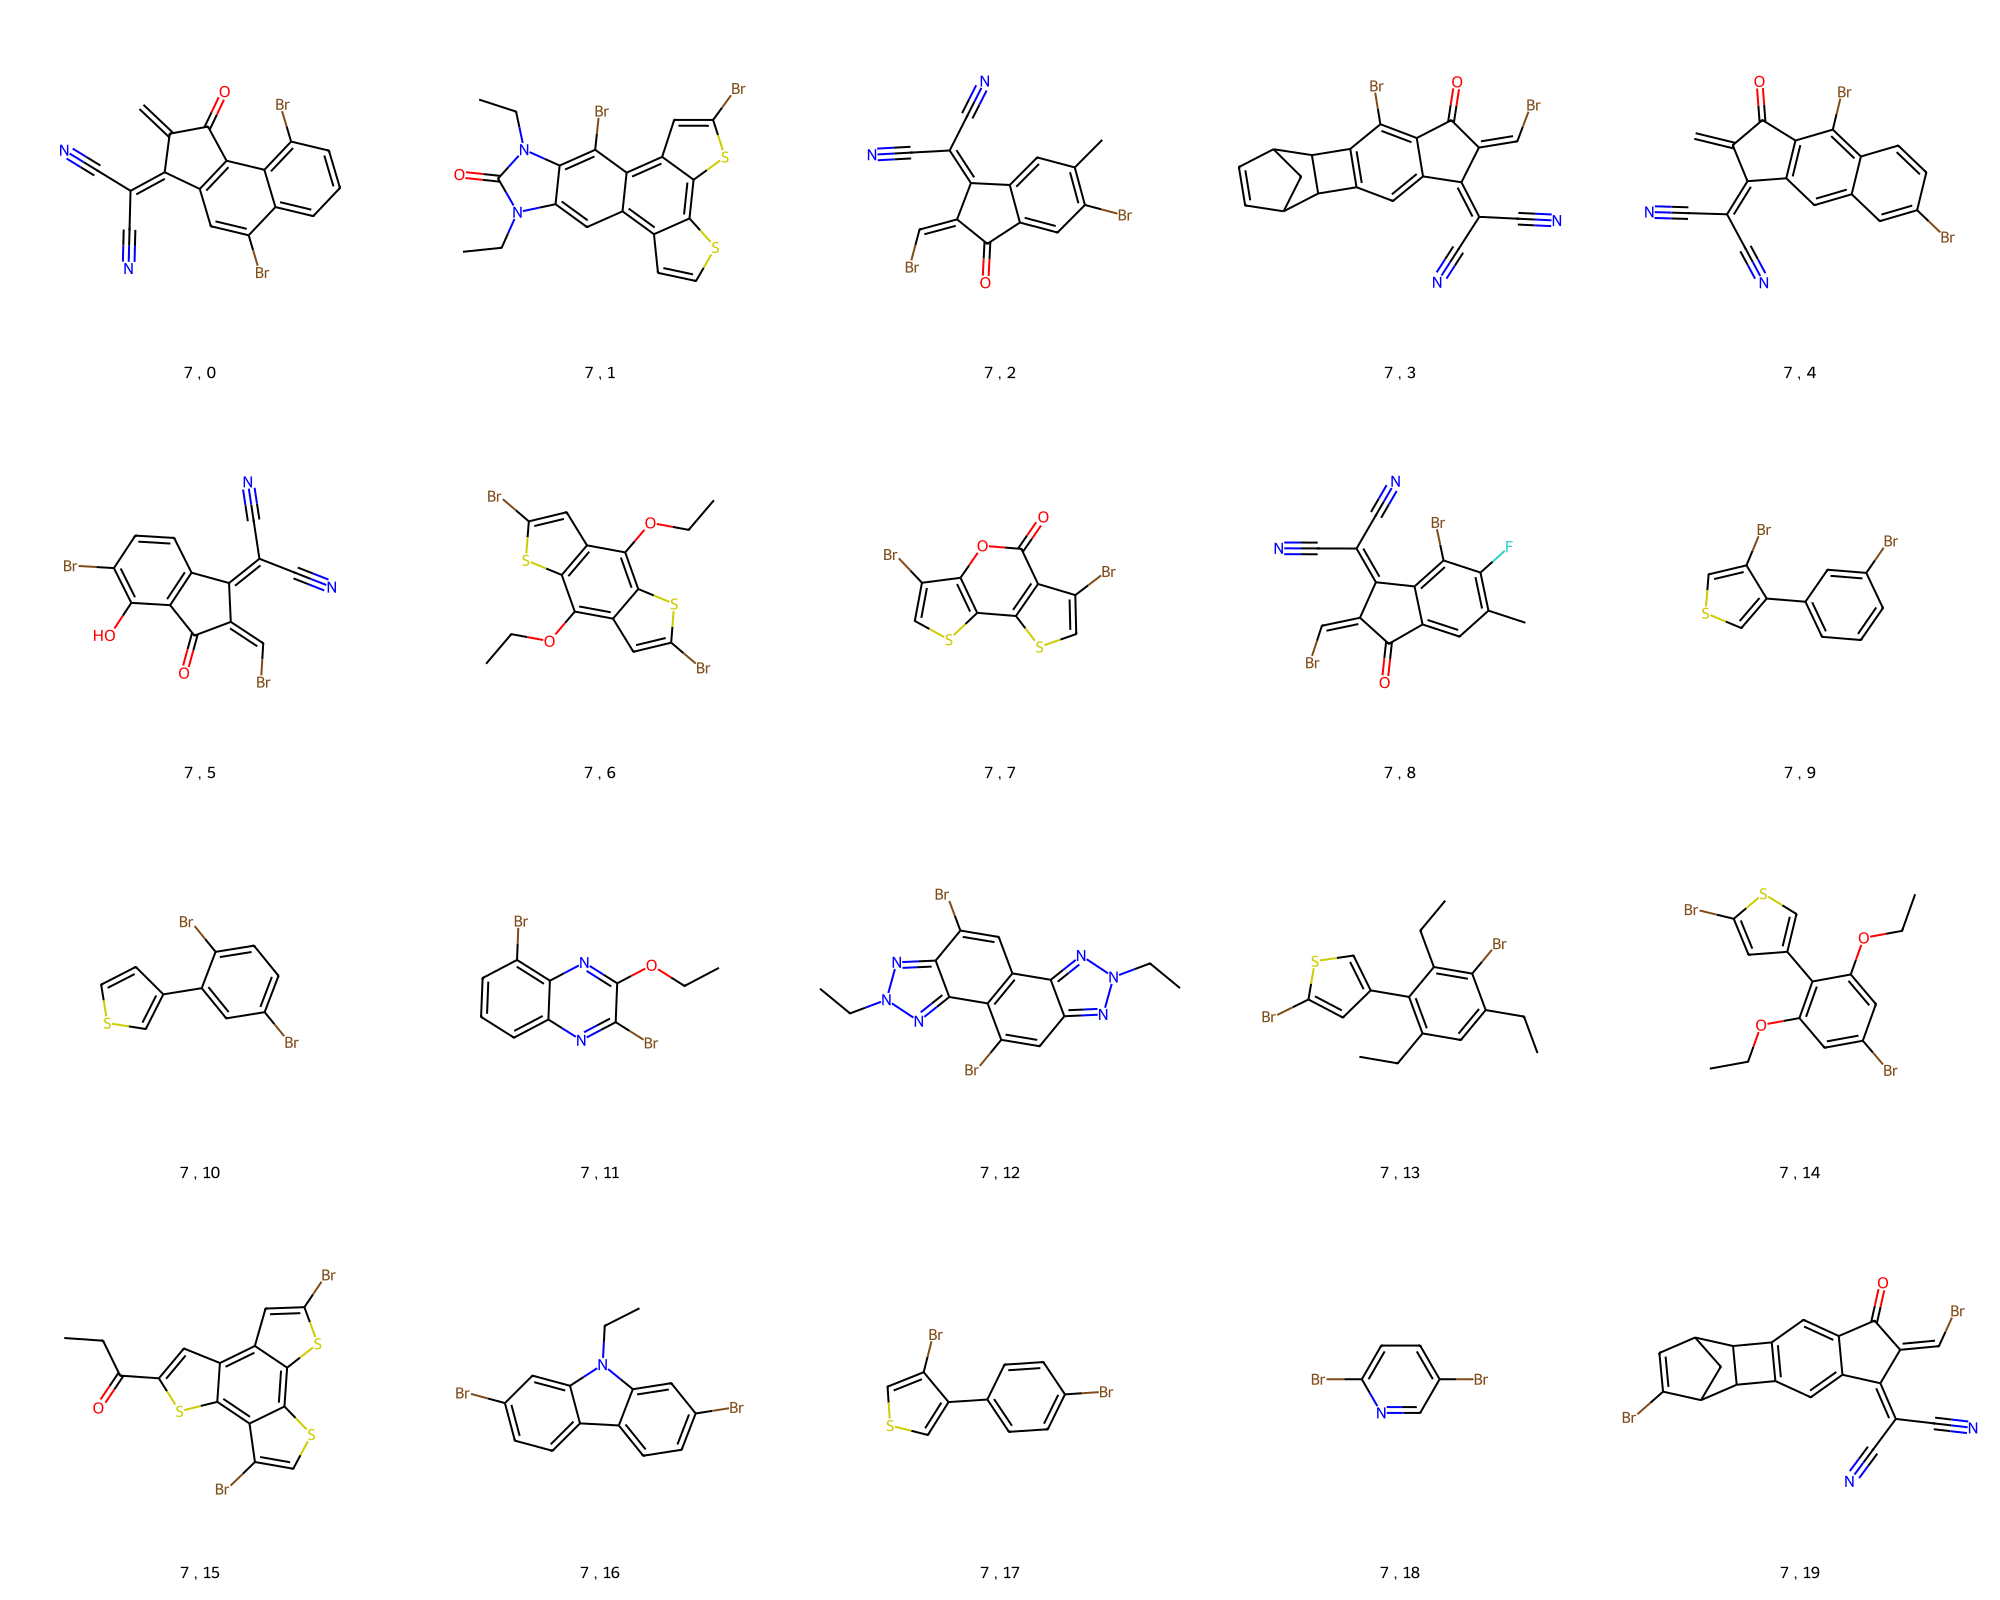

In [6]:
mol_list_smiles_all=[]
mol_list_all=[]
org_smiles=[]

for count,smiles in enumerate(df_unit_polymer['smiles']):
    mol=Chem.MolFromSmiles(smiles)
    if mol.GetNumAtoms()<30:
        mol_list,mol_list_smiles,smile=fragment_from_smiles(smiles)
        mol_list_smiles_all+=mol_list_smiles
        mol_list_all+=mol_list
        org_smiles+=smile

    #if count>12:
     #   break
print(len(mol_list_smiles_all))
mol_list_all = [Chem.MolFromSmiles(smile) for smile in set(mol_list_smiles_all)]
mol_list_all_org = [Chem.MolFromSmiles(smile) for smile in set(org_smiles)]
print(len(set(mol_list_smiles_all)))
print(len(set(org_smiles)))
img=Draw.MolsToGridImage(mol_list_all[:20],molsPerRow=5,subImgSize=(400,400),returnPNG=False,legends=[f"7 , {index}" for index, x in enumerate(mol_list_all)])    
img


Here we show the different building blocks from the same fragment

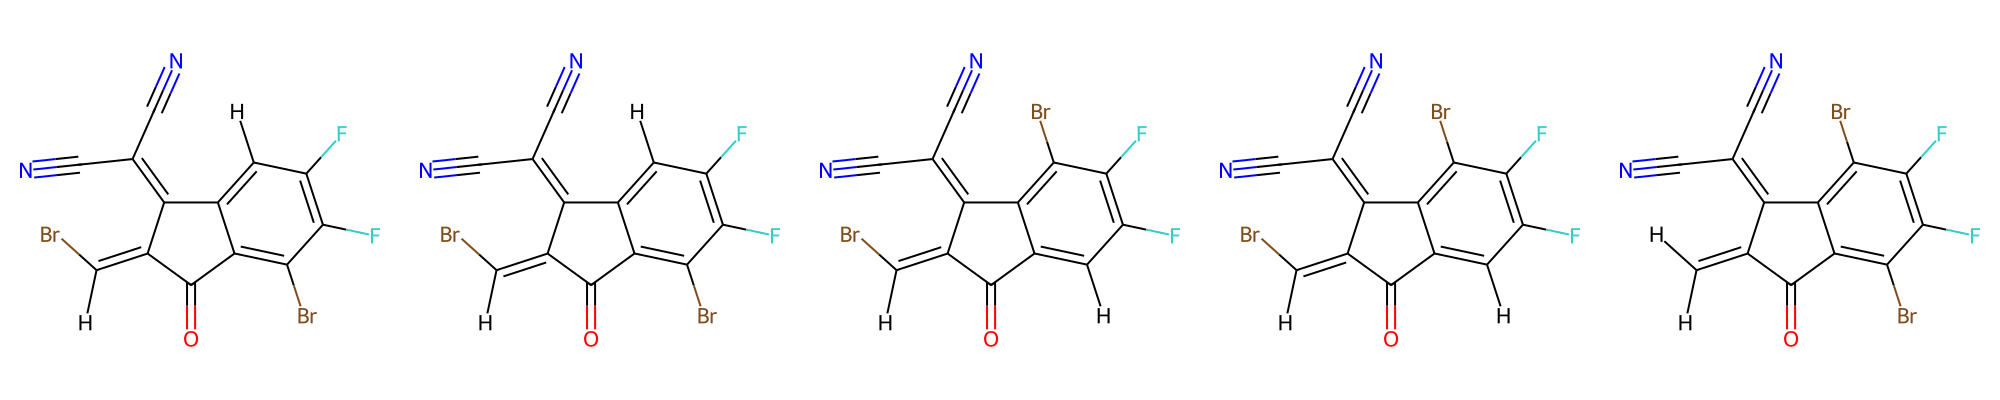

In [7]:
for count,smiles in enumerate(df_unit_polymer['smiles']):
    mol=Chem.MolFromSmiles(smiles)
    if mol.GetNumAtoms()<30:
        mol_list,mol_list_smiles,smile=fragment_from_smiles(smiles)
        break
mol
#mol_list = [Chem.MolFromSmiles(smile) for smile in set(mol_list)]
img=Draw.MolsToGridImage(mol_list,molsPerRow=5,subImgSize=(400,400),returnPNG=False)    
img

In [8]:
# save a list of smiles into a file
with open('data_example/fragment/fragementclean_1005.txt', 'w') as f:
    for item in set(mol_list_smiles_all):
        f.write("%s\n" % item)

## calculate the properties of for the building blocks and add them to the database
 this part is necessary to add the building block to the molecules database, so that we can load the building blocks to build the oligomers from there
 


In [39]:

from stk_search.utils import Precursor_calculation
import importlib
importlib.reload(Precursor_calculation)
calculator = Precursor_calculation.Calculate_Precursor()
calculator.client = "mongodb://localhost:27017/"
calculator.db_mol = 'stk_precursor' # name of the molecules database
# Change the xtb path to add the calculation to add to the database
calculator.xtb_path =None#    "xtb"
calculator.Db_folder = (
            "data/xtb_calculation/"
        )

#change the stda bin path if you want to do the calculation of the STDA to add it to the database
calculator.STDA_bin_path = None# "/home/mohammed/Work/xtb4stda/" 

os.makedirs(calculator.Db_folder, exist_ok=True)
calculator.host_IP = "cx1"
calculator.collection_name = "Precursors"




In [40]:
def add_files_to_mongo_db(client,database_name,collection_name,json_file):
    """
    This function takes a json file and add it to the mongo database
    
    Parameters
    ----------
    calculator : object
        object of the class Precursor_calculation.Calculate_Precursor()
    json_file : str
        json file name
    database_name : str
        name of the database
    """

    import json
    from pymongo import MongoClient

    client = MongoClient(client)
    db = client[database_name]
    collection = db[collection_name]

    with open(json_file) as f:
        file_data = json.load(f)
    for file in file_data:
        file.pop("_id", None)
        collection.update_many(
                filter={"InChIKey": file["InChIKey"]},
                update={"$set": file},
                upsert=True,
            )
    client.close()
# add the fragments to the database 
add_files_to_mongo_db(calculator.client,calculator.db_mol,'molecules','data_example/fragment/files_for_database/molecules.json')
add_files_to_mongo_db(calculator.client,calculator.db_mol,'building_block_position_matrices','data_example/fragment/files_for_database/building_block_position_matrices.json')
add_files_to_mongo_db(calculator.client,calculator.db_mol,'Precursors_IPEA','data_example/fragment/files_for_database/Precursors_IPEA.json')
add_files_to_mongo_db(calculator.client,calculator.db_mol,'Precursors_opt','data_example/fragment/files_for_database/Precursors_opt.json')
add_files_to_mongo_db(calculator.client,calculator.db_mol,'Precursors_Stda','data_example/fragment/files_for_database/Precursors_Stda.json')

In [41]:
for smiles in mol_list_smiles_all:
    try:
        ES1 = calculator.evaluate_element(smiles)
        print(ES1)
    except Exception as e:
        print(e)
        print(smiles)
    #ES1 = calculator.evaluate_element(smiles)
    #print(ES1)

(None, 'GVYASUPVXDSGHN-FARCUNLSSA-N')
(None, 'GVYASUPVXDSGHN-FARCUNLSSA-N')
(None, 'HNRHIGPDSSXEJA-UQCOIBPSSA-N')
(None, 'HNRHIGPDSSXEJA-UQCOIBPSSA-N')
(None, 'SNMJIXVGAOBXCS-UHFFFAOYSA-N')
(None, 'LWMBLJLODRWDDF-NYYWCZLTSA-N')
(None, 'BJFIUKSBVAJFOJ-WTKPLQERSA-N')
(None, 'LWMBLJLODRWDDF-WCIBSUBMSA-N')
(None, 'DBEZSHISDJHLRT-WCIBSUBMSA-N')
(None, 'DBEZSHISDJHLRT-WCIBSUBMSA-N')
(None, 'BJFIUKSBVAJFOJ-WTKPLQERSA-N')
(None, 'BRCXVAWJTKFNPS-RUDMXATFSA-N')
(None, 'JKHLXJQXMRYOIR-UHFFFAOYSA-N')
(None, 'BRCXVAWJTKFNPS-RUDMXATFSA-N')
(None, 'YRLHTVUVZGUJFJ-UHFFFAOYSA-N')
(None, 'YRLHTVUVZGUJFJ-UHFFFAOYSA-N')
(None, 'XHNZXCWTYWLMSA-UHFFFAOYSA-N')
(None, 'TYECWABMXAYFSG-UHFFFAOYSA-N')
(None, 'FUEMRLNZYZSYAL-UHFFFAOYSA-N')
(None, 'FVMLVXOVCFAVOY-UHFFFAOYSA-N')
(None, 'SCLMRBWNFRQGIQ-UHFFFAOYSA-N')
(None, 'UQNPYIQHMRTHET-UHFFFAOYSA-N')
(None, 'JOQLSILWMLVPTL-UHFFFAOYSA-N')
(None, 'XHNZXCWTYWLMSA-UHFFFAOYSA-N')
(None, 'TTZBPWNRCSNKSN-UHFFFAOYSA-N')
(None, 'NCUNXZGJDQPCAV-UHFFFAOYSA-N')
(None, 'SIQB

In [42]:
# helper function to load the data calculated for the precurosors
import pymongo
def load_data(collection_name = 'Precursors', client = "mongodb://localhost:27017/"
              , database = 'stk_mohammed_precursor', excited_state_calculated = False,
              xtb_calculated = False):
    client = pymongo.MongoClient(client)
    database = client[database]
    
    collection = database["molecules"]
    df_total = pd.DataFrame(list(collection.find()))
    if xtb_calculated:
        collection = database[f"{collection_name}_IPEA"]
        df_IPEA = pd.DataFrame(list(collection.find()))
        collection = database[f"{collection_name}_opt"]
        df_opt = pd.DataFrame(list(collection.find()))
        df_total = df_total.merge(df_IPEA, on="InChIKey", how="outer")
        df_opt.drop(columns=["_id","total energy (au)"],inplace=True)
        df_total = df_total.merge(df_opt, on="InChIKey", how="outer")
    if excited_state_calculated:
        collection = database[f"{collection_name}_Stda"]
        df_STDA = pd.DataFrame(list(collection.find()))
        df_total = df_total.merge(df_STDA, on="InChIKey", how="outer")
        df_total.dropna(subset=["Excited state energy (eV)"], inplace=True)
        df_total["ES1"] = df_total["Excited state energy (eV)"].apply(
            lambda x: x[0]
        )
        df_total["fosc1"] = df_total[
            "Excited state oscillator strength"
        ].apply(lambda x: x[0])
    return df_total
df_precursor= load_data(calculator.collection_name, calculator.client, calculator.db_mol, excited_state_calculated=True, xtb_calculated=True)
df_precursor.shape

(453, 23)

In [49]:
from rdkit.Chem import rdDetermineBonds
import stk

def Inch_to_mol(InChIKey, client = "mongodb://localhost:27017/"
              , database = 'stk_precursor'):
    """ 
    This function takes an InChIKey and returns the RDKit molecule
    Parameters
    ----------
    InChIKey : str
        InChIKey
    client : str
        client address
    database : str
        database name
    Returns
    -------
        mol : RDKit molecule
        RDKit molecule
    """
    client = pymongo.MongoClient(client)
    db = stk.MoleculeMongoDb(client, database=database,)
    stk_mol = db.get( {"InChIKey": InChIKey})
    return stk_mol.to_rdkit_mol()

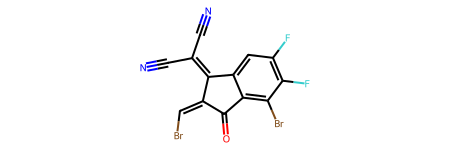

In [50]:
mol = Inch_to_mol(df_precursor['InChIKey'].iloc[0])
Chem.MolFromSmiles(Chem.MolToSmiles(mol))


# Generate a df_precursor with the properties of the fragment to include in the oligomer representation

The generation of the dataframe with the building block properties for the representation need the mongodb database to contain the fragments

In [51]:
# case of fragment properties
numeric_columns = df_precursor.select_dtypes(include= ["int", "float"]).columns
print(numeric_columns)
df_properties = df_precursor[numeric_columns]
df_properties['InChIKey'] = df_precursor['InChIKey'].copy()
#df_properties['InChIKey_initial']  = df_precursor['InChIKey_initial'] 
df_properties['mol_opt'] = df_properties['InChIKey'].apply(Inch_to_mol)
df_properties['Atom_num'] = df_properties['mol_opt'].apply(lambda x: x.GetNumAtoms())


Index(['electron affinity (eV)', 'homo lumo_gap (eV)',
       'ionisation potential (eV)', 'total energy (au)', 'HOMO-LUMO GAP (eV)',
       'ES1', 'fosc1'],
      dtype='object')


/tmp/ipykernel_212739/3709248011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_properties['InChIKey'] = df_precursor['InChIKey'].copy()
/tmp/ipykernel_212739/3709248011.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_properties['mol_opt'] = df_properties['InChIKey'].apply(Inch_to_mol)
/tmp/ipykernel_212739/3709248011.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [52]:
df_properties[df_properties['Atom_num']<30]
def check_mol(mol):
    if mol.GetNumAtoms()>=30:
        return 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() ==14:
            return 0
        if atom.GetAtomicNum() ==32:
            return 0
    return 1
df_properties['check'] = df_properties['mol_opt'].apply(check_mol)
df_properties = df_properties[df_properties['check']==1]
df_properties.drop(columns=['check'], inplace=True)
df_properties.shape

/tmp/ipykernel_212739/1527244678.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_properties['check'] = df_properties['mol_opt'].apply(check_mol)


(307, 10)

In [53]:
df_properties_path = "data_example/precursor/df_properties.pkl"
os.makedirs(os.path.dirname(df_properties_path), exist_ok=True)
df_properties.to_pickle(df_properties_path)

In [54]:
# case of mordred descriptors
from mordred import Calculator, descriptors
from sklearn.decomposition import PCA
import numpy as np  

calc = Calculator(descriptors, ignore_3D=False)
df_precursor['mol_opt'] = df_precursor['InChIKey'].apply(Inch_to_mol)
descriptors_df = calc.pandas(df_precursor["mol_opt"])

descriptors_df['InChIKey'] = df_precursor["InChIKey"]
descriptors_df.dropna(inplace=True)
PCA_model = PCA(n_components=10)
frag_properties = descriptors_df.select_dtypes(include=[np.number]).columns 

X_PCA = PCA_model.fit_transform(descriptors_df[frag_properties].values)

df_representation = pd.DataFrame(X_PCA, columns=[f"PCA_{i}" for i in range(X_PCA.shape[1])])
df_representation['InChIKey'] = descriptors_df['InChIKey']

  1%|          | 4/453 [00:02<03:57,  1.89it/s]

[11:04:10]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:10]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:10]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:10]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:10]
****


  3%|▎         | 12/453 [00:02<00:54,  8.07it/s]

[11:04:10]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:10]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:10]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:10]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:10]
****


  5%|▍         | 22/453 [00:03<00:28, 14.87it/s]

[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****


  6%|▌         | 26/453 [00:03<00:27, 15.57it/s]

----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****


  7%|▋         | 31/453 [00:03<00:23, 17.87it/s]

[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****


Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Vi

  9%|▉         | 40/453 [00:04<00:20, 20.56it/s]

Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:11]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expressio

 10%|█         | 47/453 [00:04<00:17, 23.40it/s]

[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:12]
****


 13%|█▎        | 61/453 [00:04<00:10, 37.59it/s]

[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:12]
****


 15%|█▌        | 70/453 [00:04<00:12, 29.63it/s]

[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:12]
****


Stacktrace:
----------
****
[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----

 18%|█▊        | 81/453 [00:05<00:12, 29.99it/s]

----------
Stacktrace:
----------
****
[11:04:12]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:13]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:13]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:13]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stack

 21%|██        | 96/453 [00:05<00:10, 33.58it/s]

[11:04:13]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:13]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:13]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:13]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:13]
****


 22%|██▏       | 101/453 [00:06<00:11, 31.65it/s]

[11:04:13]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:13]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:13]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:13]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:13]
****


****
[11:04:13]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:13]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:13]


 24%|██▍       | 110/453 [00:06<00:14, 23.99it/s]

[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****


 25%|██▌       | 114/453 [00:06<00:14, 22.91it/s]

[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****


 26%|██▋       | 119/453 [00:06<00:14, 22.30it/s]

[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****


 26%|██▋       | 119/453 [00:07<00:14, 22.30it/s]

[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****


 27%|██▋       | 122/453 [00:07<00:36,  9.16it/s]

[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****


 28%|██▊       | 127/453 [00:07<00:30, 10.57it/s]

[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****


 29%|██▉       | 132/453 [00:08<00:20, 15.61it/s]

Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:15]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:15]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expressio

 30%|███       | 136/453 [00:08<00:18, 17.56it/s]

****
[11:04:15]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:15]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]


 31%|███       | 141/453 [00:08<00:15, 20.25it/s]

[11:04:15]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:15]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:14]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****


 34%|███▍      | 153/453 [00:09<00:12, 23.31it/s]

[11:04:15]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:15]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:15]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:15]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:15]
****


 35%|███▍      | 158/453 [00:09<00:10, 26.95it/s]

****


 37%|███▋      | 169/453 [00:09<00:09, 31.28it/s]

[11:04:15]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:15]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:15]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:15]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:15]
****


----------
****
[11:04:16]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:16]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:16]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:16]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****


----------
****
[11:04:16]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:16]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:16]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:16]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****


 40%|████      | 183/453 [00:10<00:11, 23.18it/s]

----------
Stacktrace:
----------
****
[11:04:16]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:16]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:16]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:16]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stack

 42%|████▏     | 189/453 [00:10<00:11, 22.90it/s]

RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:17]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:17]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:17]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:17]
****
Pre-condition Violation
RingInfo not ini

 42%|████▏     | 192/453 [00:10<00:10, 24.34it/s]

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:17]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:17]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:17]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:17]
****
Pre-conditi

 43%|████▎     | 197/453 [00:10<00:12, 21.14it/s]

[11:04:17]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:17]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:17]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:17]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:17]
****


 45%|████▍     | 202/453 [00:10<00:10, 22.98it/s]

RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****
Pre-condition Violation
RingInfo not ini

 45%|████▌     | 206/453 [00:11<00:10, 22.50it/s]

RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****
Pre-condition Violation
RingInfo not ini

 47%|████▋     | 211/453 [00:11<00:10, 23.20it/s]

[11:04:18]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****


 48%|████▊     | 217/453 [00:11<00:09, 24.36it/s]

[11:04:18]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****


 49%|████▉     | 223/453 [00:11<00:09, 25.43it/s]

[11:04:18]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:18]
****


 50%|█████     | 228/453 [00:12<00:08, 26.19it/s]

----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stack

 51%|█████     | 230/453 [00:12<00:12, 18.48it/s]

[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****


 51%|█████     | 230/453 [00:12<00:12, 18.48it/s]

[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****


 51%|█████▏    | 233/453 [00:12<00:18, 11.67it/s]

[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****


 53%|█████▎    | 239/453 [00:13<00:13, 16.40it/s]

[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****


 54%|█████▍    | 245/453 [00:13<00:10, 19.04it/s]

[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****


 55%|█████▍    | 248/453 [00:13<00:11, 18.20it/s]

[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****


[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:19]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:20]
****


 57%|█████▋    | 257/453 [00:13<00:09, 20.81it/s]

RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:20]
****
Pre-condition Violation
RingInfo not ini

 58%|█████▊    | 263/453 [00:14<00:08, 23.00it/s]

[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****


 59%|█████▉    | 267/453 [00:14<00:07, 23.71it/s]

----------
Stacktrace:
----------
****
[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stack

[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****


 62%|██████▏   | 280/453 [00:14<00:05, 30.01it/s]

[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:20]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****


 63%|██████▎   | 285/453 [00:14<00:05, 28.46it/s]

[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****


 64%|██████▍   | 290/453 [00:15<00:06, 25.46it/s]

[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****


 65%|██████▌   | 296/453 [00:15<00:06, 24.75it/s]

[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:21]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:22]
****


 68%|██████▊   | 306/453 [00:15<00:04, 34.98it/s]

[11:04:22]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:22]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:22]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:22]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:22]
****


[11:04:22]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:22]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:23]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:23]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:22]
****


 70%|██████▉   | 315/453 [00:15<00:05, 26.77it/s]

[11:04:23]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:23]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:23]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:23]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:23]
****


 71%|███████   | 320/453 [00:16<00:04, 27.44it/s]

RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:23]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:23]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:23]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:23]
****
Pre-condition Violation
RingInfo not ini

 72%|███████▏  | 325/453 [00:16<00:05, 25.53it/s]

----------
Stacktrace:
----------
****
[11:04:23]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:23]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:23]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:23]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stack

 73%|███████▎  | 330/453 [00:16<00:04, 24.72it/s]

Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:23]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Vi

 74%|███████▎  | 333/453 [00:16<00:05, 22.89it/s]

[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****


 75%|███████▍  | 339/453 [00:16<00:04, 23.45it/s]

[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****


 75%|███████▌  | 340/453 [00:17<00:04, 23.45it/s]

[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****


 75%|███████▌  | 342/453 [00:17<00:08, 12.55it/s]

[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****


[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****


 77%|███████▋  | 349/453 [00:18<00:07, 14.55it/s]

Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurr

 78%|███████▊  | 355/453 [00:18<00:05, 18.74it/s]

[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****


 79%|███████▉  | 360/453 [00:18<00:04, 23.14it/s]

[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:24]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****


 81%|████████  | 365/453 [00:18<00:04, 20.43it/s]

[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****


 82%|████████▏ | 372/453 [00:18<00:03, 24.23it/s]

[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****


 83%|████████▎ | 376/453 [00:19<00:03, 22.81it/s]

[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****


 85%|████████▌ | 386/453 [00:19<00:02, 25.97it/s]

[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:25]
****


 88%|████████▊ | 399/453 [00:19<00:01, 38.26it/s]

RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:26]
****
Pre-condition Violation
RingInfo not ini

Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:26]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:26]
****
Pre-condition Vi

 95%|█████████▍| 429/453 [00:19<00:00, 69.71it/s]

RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:27]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:27]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:27]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:27]
****
Pre-condition Violation
RingInfo not ini

 98%|█████████▊| 445/453 [00:20<00:00, 75.07it/s]

Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:28]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:28]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:28]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:28]
****
Pre-condition Vi

100%|██████████| 453/453 [00:20<00:00, 22.37it/s]


----------
Stacktrace:
----------
****
[11:04:29]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:29]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:29]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stacktrace:
----------
****
[11:04:29]
****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 28 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
----------
Stack

In [55]:
df_representation_path = "data_example/precursor/df_mordred_24072024.pkl"
os.makedirs(os.path.dirname(df_representation_path), exist_ok=True)
df_representation.to_pickle(df_representation_path)